# Préparation et nettoyage des données DVF

**Objectif** : préparer un jeu de données propre pour l'analyse des **locaux commerciaux / boutiques** à **Paris** (arrondissements, prix/m², année, géolocalisation).



In [ ]:
import pandas as pd
import numpy as np
import os

# ============================================================================== 
# CHARGEMENT DES DONNÉES PAR MORCEAUX (CHUNKS)
# ==============================================================================

print("Chargement des données DVF par morceaux...")

# Définir les colonnes à garder dès le chargement
colonnes_importantes = [
    'date_mutation',
    'valeur_fonciere',
    'code_postal',
    'type_local',
    'surface_reelle_bati',
    'nombre_pieces_principales',
    'longitude',
    'latitude',
    'adresse_nom_voie',
    'code_commune'
]

# Initialiser une liste pour stocker les chunks filtrés
chunks_filtres = []

# Taille des chunks (ajustable selon votre RAM)
chunk_size = 100000

# Compteur de lignes traitées
total_lines = 0
kept_lines = 0
chunk_idx = 0

# Lire le fichier par morceaux
try:
    for chunk in pd.read_csv('dvf.csv', 
                             chunksize=chunk_size, 
                             low_memory=False,
                             usecols=lambda x: x in colonnes_importantes,
                             dtype={'code_postal': str}):
        
        chunk_idx += 1
        total_lines += len(chunk)
        
        # Normaliser code_postal en chaîne 5 caractères
        if 'code_postal' in chunk.columns:
            chunk['code_postal'] = chunk['code_postal'].astype(str).str.zfill(5)
        
        # FILTRAGE IMMÉDIAT pour ne garder que ce qui nous intéresse
        
        # 1. Filtrer Paris uniquement (codes 75xxx)
        chunk = chunk[chunk['code_postal'].str.startswith('75', na=False)]
        
        # 2. Filtrer les locaux commerciaux / boutiques (plus large)
        # On cherche 'commercial', 'commerce' ou 'boutique' (insensible à la casse)
        chunk = chunk[chunk['type_local'].astype(str).str.contains(r'commercial|commerce|boutique', case=False, na=False)]
        
        # 3. Supprimer les valeurs manquantes critiques (valeur & surface)
        chunk['valeur_fonciere'] = pd.to_numeric(chunk['valeur_fonciere'], errors='coerce')
        chunk['surface_reelle_bati'] = pd.to_numeric(chunk['surface_reelle_bati'], errors='coerce')
        chunk = chunk[chunk['valeur_fonciere'].notna() & chunk['surface_reelle_bati'].notna()]
        
        # 4. Filtrer les valeurs aberrantes (bornes raisonnables)
        chunk = chunk[(chunk['valeur_fonciere'] > 0) & (chunk['valeur_fonciere'] < 50_000_000)]
        chunk = chunk[(chunk['surface_reelle_bati'] > 0) & (chunk['surface_reelle_bati'] < 10000)]
        
        # Si le chunk contient des données après filtrage, le garder
        if len(chunk) > 0:
            chunks_filtres.append(chunk)
            kept_lines += len(chunk)
        
        # Afficher la progression tous les 2 chunks
        if chunk_idx % 2 == 0:
            print(f"Chunks traités: {chunk_idx:,} | Traité: {total_lines:,} lignes | Conservé (raw chunks): {kept_lines:,} lignes")

except Exception as e:
    print(f"Erreur lors du chargement : {e}")
    print("Vérifiez que le fichier s'appelle bien 'dvf.csv'")

print(f"\nTotal traité : {total_lines:,} lignes")
print(f"Total conservé (avant concat): {kept_lines:,} lignes")

# ============================================================================== 
# CONCATÉNATION DES CHUNKS
# ==============================================================================

if len(chunks_filtres) == 0:
    print("\n⚠️ Aucune donnée trouvée ! Vérifiez les noms de colonnes.")
else:
    print("\nConcaténation des données filtrées...")
    df = pd.concat(chunks_filtres, ignore_index=True)
    print(f"Dataset après concaténation : {len(df):,} lignes")

    # --------------------------------------------------------------------------
    # SUPPRESSION DES DOUBLONS (lignes identiques)
    # --------------------------------------------------------------------------
    before_dup = len(df)
    df = df.drop_duplicates()
    removed_dup = before_dup - len(df)
    print(f"Doublons exacts supprimés : {removed_dup} lignes (avant: {before_dup:,} -> après: {len(df):,})")

    # --------------------------------------------------------------------------
    # SUPPRESSION DES LIGNES SANS COORDONNÉES (latitude / longitude)
    # --------------------------------------------------------------------------
    before_coords = len(df)
    # Forcer numeric pour latitude/longitude et considérer NaN
    if 'latitude' in df.columns:
        df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
    if 'longitude' in df.columns:
        df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
    df = df.dropna(subset=['latitude', 'longitude'])
    removed_coords = before_coords - len(df)
    print(f"Lignes sans coordonnées supprimées : {removed_coords} (avant: {before_coords:,} -> après: {len(df):,})")

    # =======================================================================
    # NETTOYAGE SUPPLÉMENTAIRE ET CRÉATION DE VARIABLES
    # =======================================================================
    
    print("\n=== Création de variables dérivées ===")
    
    # Calcul du prix au m²
    df['prix_m2'] = df['valeur_fonciere'] / df['surface_reelle_bati']
    
    # Nettoyage des prix au m² aberrants (bornes conservées)
    df = df[(df['prix_m2'] > 500) & (df['prix_m2'] < 50000)]
    print(f"Après filtrage prix au m² : {len(df):,} lignes")
    
    # Extraction de l'arrondissement (normalisation de code_postal)
    df['code_postal'] = df['code_postal'].astype(str).str.zfill(5)
    # on extrait les deux derniers chiffres ; on convertit en int puis on vérifie 1..20
    df['arrondissement'] = pd.to_numeric(df['code_postal'].str[-2:], errors='coerce')
    df.loc[~df['arrondissement'].between(1,20), 'arrondissement'] = np.nan
    # convertir en int propre si besoin
    df['arrondissement'] = df['arrondissement'].dropna().astype(int)
    
    # Conversion de la date
    df['date_mutation'] = pd.to_datetime(df['date_mutation'], errors='coerce')
    
    # Extraction année, mois, trimestre
    df['annee'] = df['date_mutation'].dt.year
    df['mois'] = df['date_mutation'].dt.month
    df['trimestre'] = df['date_mutation'].dt.quarter
    
    # =======================================================================
    # STATISTIQUES FINALES
    # =======================================================================
    
    print("\n=== Statistiques des données nettoyées ===")
    print(f"Nombre total de transactions (final) : {len(df):,}")
    print(f"Période couverte : {df['date_mutation'].min()} à {df['date_mutation'].max()}")
    print(f"\nRépartition par arrondissement :")
    # tri par arrondissement (gérer NaN)
    print(df['arrondissement'].value_counts(dropna=False).sort_index())
    print(f"\nStatistiques des prix au m² :")
    print(df['prix_m2'].describe())
    
    # =======================================================================
    # SAUVEGARDE
    # =======================================================================
    
    print("\n=== Sauvegarde des données nettoyées ===")
    out_name = 'dvf_paris_commerces_clean.csv'
    df.to_csv(out_name, index=False)
    print(f"✓ Fichier sauvegardé : {out_name}")
    
    # Afficher la taille du fichier
    file_size = os.path.getsize(out_name) / (1024 * 1024)
    print(f"Taille du fichier : {file_size:.2f} MB")
    
    print("\n✓ Nettoyage terminé avec succès !")


Chargement des données DVF par morceaux...
Chunks traités: 2 | Traité: 200,000 lignes | Conservé (raw chunks): 0 lignes
Chunks traités: 4 | Traité: 400,000 lignes | Conservé (raw chunks): 0 lignes
Chunks traités: 6 | Traité: 600,000 lignes | Conservé (raw chunks): 0 lignes
Chunks traités: 8 | Traité: 800,000 lignes | Conservé (raw chunks): 0 lignes
Chunks traités: 10 | Traité: 1,000,000 lignes | Conservé (raw chunks): 0 lignes
Chunks traités: 12 | Traité: 1,200,000 lignes | Conservé (raw chunks): 0 lignes
Chunks traités: 14 | Traité: 1,400,000 lignes | Conservé (raw chunks): 0 lignes
Chunks traités: 16 | Traité: 1,600,000 lignes | Conservé (raw chunks): 0 lignes
Chunks traités: 18 | Traité: 1,800,000 lignes | Conservé (raw chunks): 0 lignes
Chunks traités: 20 | Traité: 2,000,000 lignes | Conservé (raw chunks): 0 lignes
Chunks traités: 22 | Traité: 2,200,000 lignes | Conservé (raw chunks): 0 lignes
Chunks traités: 24 | Traité: 2,400,000 lignes | Conservé (raw chunks): 0 lignes
Chunks tr

✅ Fichier chargé : dvf_paris_commerces_clean.csv
Lignes: 16945 | Colonnes: 15

Colonnes : ['date_mutation', 'valeur_fonciere', 'adresse_nom_voie', 'code_postal', 'code_commune', 'type_local', 'surface_reelle_bati', 'nombre_pieces_principales', 'longitude', 'latitude', 'prix_m2', 'arrondissement', 'annee', 'mois', 'trimestre']
  date_mutation  valeur_fonciere      adresse_nom_voie  code_postal  \
0    2020-01-17        3400000.0  AV FERDINAND BUISSON        75016   
1    2020-01-06         878378.0    BD DE LA MADELEINE        75001   
2    2020-01-13         475000.0     RUE DE WASHINGTON        75008   
3    2020-01-03         800000.0      BD DE SEBASTOPOL        75003   
4    2020-01-06         710000.0      RUE SAINT HONORE        75001   

   code_commune                                type_local  \
0         92012  Local industriel. commercial ou assimilé   
1         75101  Local industriel. commercial ou assimilé   
2         75108  Local industriel. commercial ou assimilé   
3

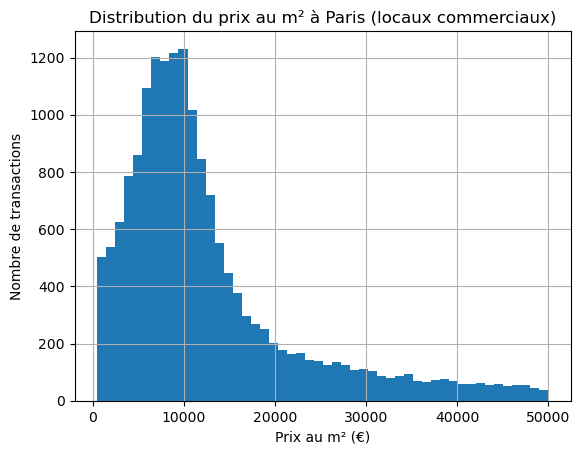

In [8]:

import matplotlib.pyplot as plt
# === CONFIGURATION ===
FILE_PATH = "dvf_paris_commerces_clean.csv"

# Seuils de détection
SMALL_SURFACE = 5       # m² (suspect si < 5)
LARGE_SURFACE = 5000    # m² (suspect si > 5000)
PRIX_M2_MIN = 200       # €/m²
PRIX_M2_MAX = 100000    # €/m²
IQR_MULT = 1.5          # multiplicateur IQR
Z_THRESH = 3.0          # z-score

# === CHARGEMENT ===
df = pd.read_csv(FILE_PATH)
print("✅ Fichier chargé :", FILE_PATH)
print(f"Lignes: {len(df)} | Colonnes: {len(df.columns)}")
print("\nColonnes :", list(df.columns))

print(df.head())
# === VALEURS MANQUANTES ===
print("\n--- Vérification des valeurs manquantes ---")
missing = df.isna().sum()
print(missing[missing > 0].sort_values(ascending=False) if missing.any() else "Aucune valeur manquante.")

# === DÉTECTION DE DOUBLONS ===
duplicates = df.duplicated().sum()
print(f"\n--- Doublons exacts ---\n{duplicates} doublons détectés.")

# === VALIDATION CODE POSTAL / ARRONDISSEMENT ===
if 'code_postal' in df.columns:
    bad_cp = df[~df['code_postal'].astype(str).str.match(r'75\d{2}', na=False)]
    print(f"\nCodes postaux non parisiens : {len(bad_cp)}")
if 'arrondissement' in df.columns:
    bad_arr = df[~df['arrondissement'].between(1, 20, inclusive="both")]
    print(f"Arrondissements invalides : {len(bad_arr)}")

# === SURFACE ===
if 'surface_reelle_bati' in df.columns:
    s = pd.to_numeric(df['surface_reelle_bati'], errors='coerce')
    print("\n--- Analyse des surfaces ---")
    print(f"Surfaces manquantes : {s.isna().sum()}")
    print(f"Surfaces < {SMALL_SURFACE} m² : {(s < SMALL_SURFACE).sum()}")
    print(f"Surfaces > {LARGE_SURFACE} m² : {(s > LARGE_SURFACE).sum()}")
    print(s.describe())

# === PRIX AU M² ===
if 'prix_m2' in df.columns:
    p = pd.to_numeric(df['prix_m2'], errors='coerce')
    print("\n--- Analyse du prix au m² ---")
    print(p.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]))
    print(f"prix_m2 < {PRIX_M2_MIN} : {(p < PRIX_M2_MIN).sum()}")
    print(f"prix_m2 > {PRIX_M2_MAX} : {(p > PRIX_M2_MAX).sum()}")

    # Détection des outliers
    q1, q3 = p.quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - IQR_MULT * iqr, q3 + IQR_MULT * iqr
    outliers_iqr = ((p < low) | (p > high)).sum()
    print(f"Outliers (IQR) : {outliers_iqr} (bornes {low:.1f} - {high:.1f})")

    z = (p - p.mean()) / p.std()
    outliers_z = (abs(z) > Z_THRESH).sum()
    print(f"Outliers (z-score > {Z_THRESH}) : {outliers_z}")

# === COORDONNÉES GÉOGRAPHIQUES ===
if 'latitude' in df.columns and 'longitude' in df.columns:
    lat = pd.to_numeric(df['latitude'], errors='coerce')
    lon = pd.to_numeric(df['longitude'], errors='coerce')
    print("\n--- Vérification des coordonnées géographiques ---")
    print(f"Coordonnées manquantes : {(lat.isna() | lon.isna()).sum()}")
    print(f"Latitude hors Paris (48.80–48.92) : {(~lat.between(48.80, 48.92)).sum()}")
    print(f"Longitude hors Paris (2.25–2.42) : {(~lon.between(2.25, 2.42)).sum()}")

print("\n✅ Analyse terminée.")


df['prix_m2'].hist(bins=50)
plt.title("Distribution du prix au m² à Paris (locaux commerciaux)")
plt.xlabel("Prix au m² (€)")
plt.ylabel("Nombre de transactions")
plt.show()